## imports and such

In [1]:
import sys, os
sys.path.append(os.path.realpath(".."))
os.environ["TF_XLA_FLAGS"]="--tf_xla_cpu_global_jit"

import tensorflow as tf
# tf.enable_eager_execution()
# tf.enable_v2_behavior()
# sess = tf.InteractiveSession()
# sess.as_default()

import util_funcs
from importlib import reload
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import constants
import clinical_text_analysis as cta
import tsfresh
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from os import path
from addict import Dict
import time

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ms994/miniconda3/envs/keras-

In [2]:
from preprocessingV2 import tfrecord_mappers as tfm
reload(tfm)

<module 'preprocessingV2.tfrecord_mappers' from '/home/ms994/dbmi_eeg_clustering/preprocessingV2/tfrecord_mappers.py'>

In [3]:
train_unbalanced = tfm.get_batched_dataset(["/n/scratch2/ms994/train_4s.tfr"], map_function=tfm.read_tfrecord_autoencoder, batch_size=256,  is_train=True)
valid_data = tfm.get_batched_dataset(["/n/scratch2/ms994/valid_4s.tfr"], map_function=tfm.read_tfrecord_autoencoder,batch_size=256, is_train=False)
test_data = tfm.get_batched_dataset(["/n/scratch2/ms994/test_4s.tfr"], map_function=tfm.read_tfrecord_autoencoder,batch_size=256, is_train=False)

In [4]:
g_noise=1
num_lstm_layers=3
lstm_h=128
cnn2d_n_k=2
num_cnn_layers=3
lr = 0.001

inputLayer = tf.keras.layers.Input((1000,21, 1))
x = inputLayer

x = tf.keras.layers.GaussianNoise(g_noise)(x)
for i in range(num_cnn_layers):
#     x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(cnn2d_n_k**i, (3,3), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool2D((2,1))(x)
old_x_shape = (x).get_shape().as_list()
x = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]) * int(x.shape[3])), name="LSTM_Reshape")(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.CuDNNLSTM(int(lstm_h/2**j), return_sequences=True, kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.1, l2=0.1))(x)
    x = tf.keras.layers.LeakyReLU()(x)
x_shared = x
for j in range(num_lstm_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.CuDNNLSTM(int(lstm_h/2**(num_lstm_layers-j-1)), return_sequences=True, kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.1, l2=0.1))(x)
    x = tf.keras.layers.LeakyReLU()(x)
#decoder
x = tf.keras.layers.CuDNNLSTM(old_x_shape[2]*old_x_shape[3], return_sequences=True, name="lstm_decode")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Reshape(old_x_shape[1:], name="reshape_decode")(x)
for i in range(num_cnn_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(cnn2d_n_k**(num_cnn_layers-i-1), (3,3), padding="same")(x)
    x = tf.keras.layers.UpSampling2D((2,1))(x)
    x = tf.keras.layers.LeakyReLU()(x)

x_decode = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]), int(x.shape[3])), name="decode")(x)

model = tf.keras.Model(inputs=inputLayer, outputs=x_decode)
model.compile(tf.keras.optimizers.Adam(lr=lr),  loss=["logcosh"], metrics=["mean_squared_error"])
batch_size=128
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000, 21, 1)       0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 1000, 21, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1000, 21, 1)       10        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1000, 21, 1)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 500, 21, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 500, 21, 2)        20        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 500, 21, 2)        0         
__________

In [5]:
modelCheck = tf.keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/cnn_lstm_autoencoder_seizure.h5", save_best_only=True, verbose=1)
earlyStopping = tf.keras.callbacks.EarlyStopping(patience=20)
history = model.fit(train_unbalanced, validation_data=valid_data, steps_per_epoch=500, validation_steps=100, epochs=1000, callbacks=[modelCheck, earlyStopping])

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Epoch 1/1000
499/500 [============================>.] - ETA: 0s - loss: 1442.7456 - mean_squared_error: 106.8508
Epoch 00001: val_loss improved from inf to 3682.21778, saving model to /n/scratch2/ms994/cnn_lstm_autoencoder_seizure.h5
500/500 [==============================] - 210s 419ms/step - loss: 1441.8190 - mean_squared_error: 106.7862 - val_loss: 3682.2178 - val_mean_squared_error: 13979.3311
Epoch 2/1000
499/500 [============================>.] - ETA: 0s - loss: 824.9286 - mean_squared_error: 57.9165
Epoch 00002: val_loss improved from 3682.21778 to 3185.52252, saving model to /n/scratch2/ms994/cnn_lstm_autoencoder_seizure.h5
500/500 [==============================] - 201s 401ms/step - loss: 824.6491 - mean_squared_error: 57.8853 - val_loss: 3185.5225 - val_mean_squared_error: 13573.5498
Epoch 3/1000
499/500 [============================>.] - ETA: 0s - loss: 677.1411 - mean_squared_error: 44.7721
Epoch 00003: val_loss improved from 3185.52252 to 2805.92071, saving model to /n/scr

Epoch 24/1000
499/500 [============================>.] - ETA: 0s - loss: 543.8604 - mean_squared_error: 35.5517
Epoch 00024: val_loss did not improve from 2460.79597
500/500 [==============================] - 200s 400ms/step - loss: 543.8786 - mean_squared_error: 35.5474 - val_loss: 2788.7009 - val_mean_squared_error: 12384.0254
Epoch 25/1000
499/500 [============================>.] - ETA: 0s - loss: 541.4901 - mean_squared_error: 35.3384
Epoch 00025: val_loss did not improve from 2460.79597
500/500 [==============================] - 201s 402ms/step - loss: 541.5898 - mean_squared_error: 35.3552 - val_loss: 3007.8013 - val_mean_squared_error: 14214.6777
Epoch 26/1000
499/500 [============================>.] - ETA: 0s - loss: 540.1190 - mean_squared_error: 35.1419
Epoch 00026: val_loss did not improve from 2460.79597
500/500 [==============================] - 201s 402ms/step - loss: 540.2376 - mean_squared_error: 35.1626 - val_loss: 2766.0878 - val_mean_squared_error: 13242.8779
Epoch 2

# Show the history graphs

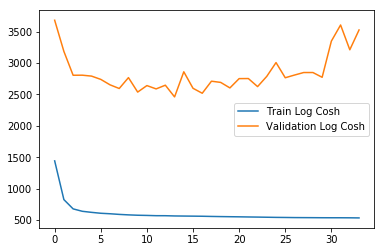

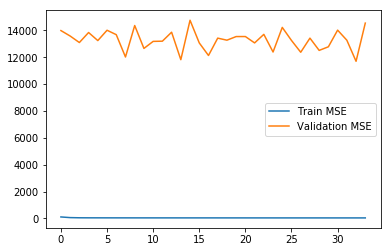

In [6]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Train Log Cosh", "Validation Log Cosh"])
plt.show()
plt.plot(history.history["mean_squared_error"])
plt.plot(history.history["val_mean_squared_error"])
plt.legend(["Train MSE", "Validation MSE"])
plt.show()


# Let's try an example from train set

In [11]:
xData = []
with tf.Session() as sess:
    iterator = train_unbalanced.take(10).make_one_shot_iterator().get_next()
    for i in range(10):
            xData.append(iterator[0].eval())

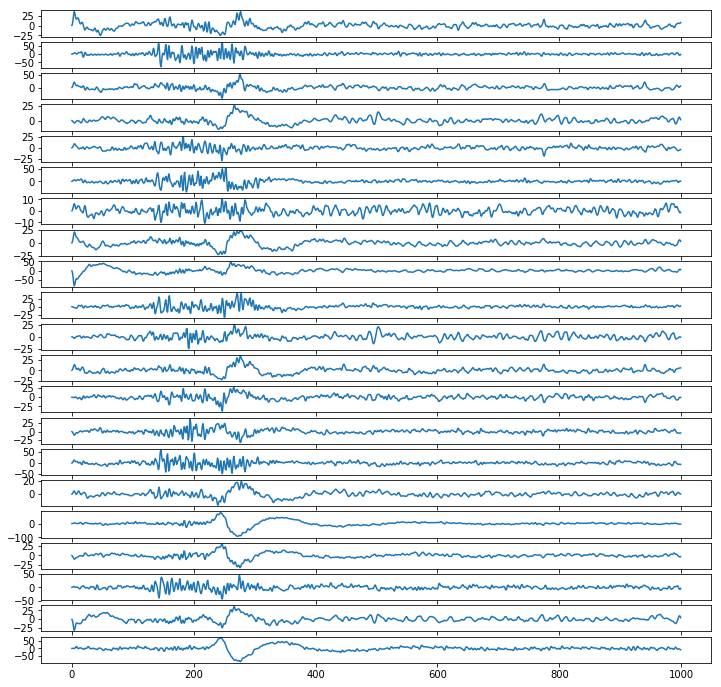

In [12]:
plt.subplots(21,1, figsize=(12,12))
for i in range(21):
    plt.subplot(21,1,i+1)
    plt.plot(xData[0][0].reshape(1000,21).transpose()[i])

In [13]:
predictedX = model.predict(xData[0][0].reshape(1,1000,21,1))

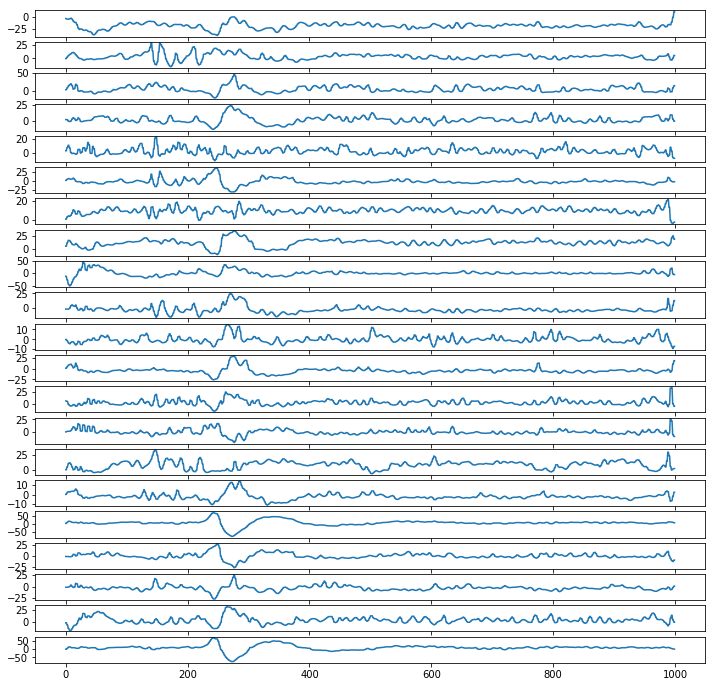

In [14]:
plt.subplots(21,1, figsize=(12,12))
for i in range(21):
    plt.subplot(21,1,i+1)
    plt.plot(predictedX[0].reshape(1000,21).transpose()[i])

# Try to look at validation and testing

In [19]:
xData = []
with tf.Session() as sess:
    iterator = valid_data.take(10).make_one_shot_iterator().get_next()
    for i in range(10):
            xData.append(iterator[0].eval())

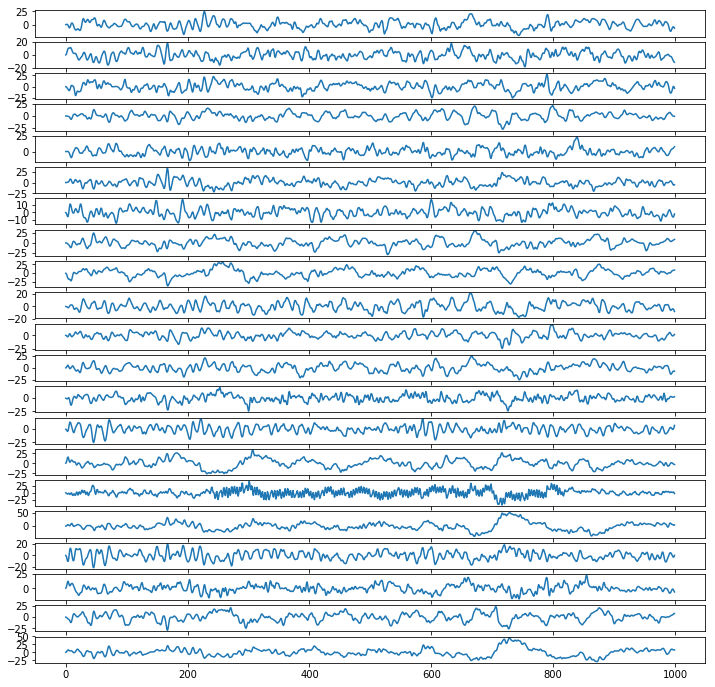

In [20]:
plt.subplots(21,1, figsize=(12,12))
for i in range(21):
    plt.subplot(21,1,i+1)
    plt.plot(xData[0][0].reshape(1000,21).transpose()[i])

In [21]:
predictedX = model.predict(xData[0][0].reshape(1,1000,21,1))

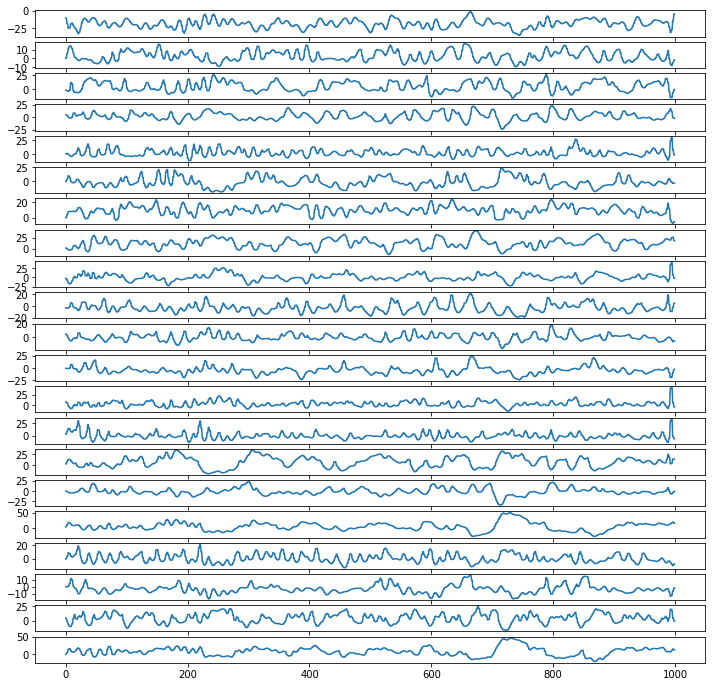

In [22]:
plt.subplots(21,1, figsize=(12,12))
for i in range(21):
    plt.subplot(21,1,i+1)
    plt.plot(predictedX[0].reshape(1000,21).transpose()[i])

In [23]:
# for j in range(10):
def show_for_instance(j):
    plt.subplots(21,2, figsize=(12,12))
    for i in range(21):
        plt.subplot(21,2,2*i+1)
        plt.plot(xData[0][j].reshape(1000,21).transpose()[i])
    predictedX = model.predict(xData[0][j].reshape(1,1000,21,1))
    for i in range(21):
        plt.subplot(21,2,2*i+2)
        plt.plot(predictedX[0].reshape(1000,21).transpose()[i])
    plt.show()

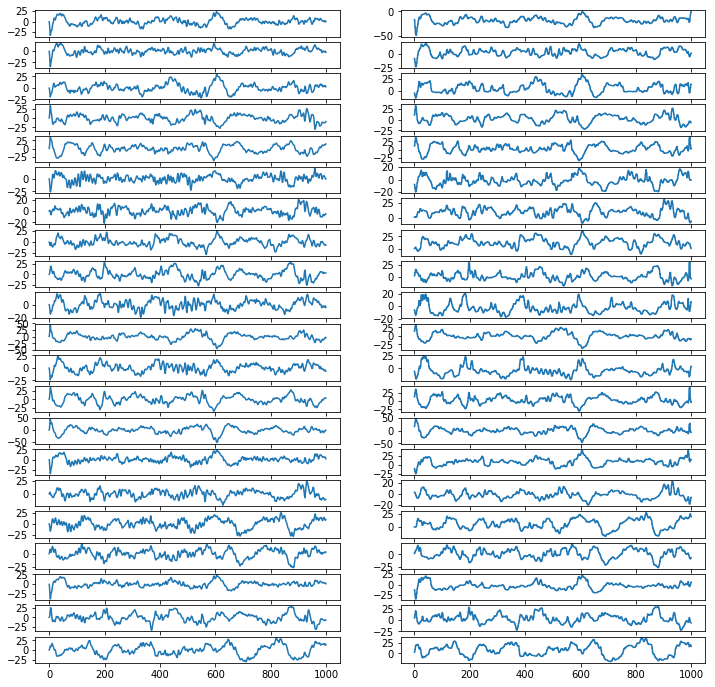

In [24]:
show_for_instance(1)

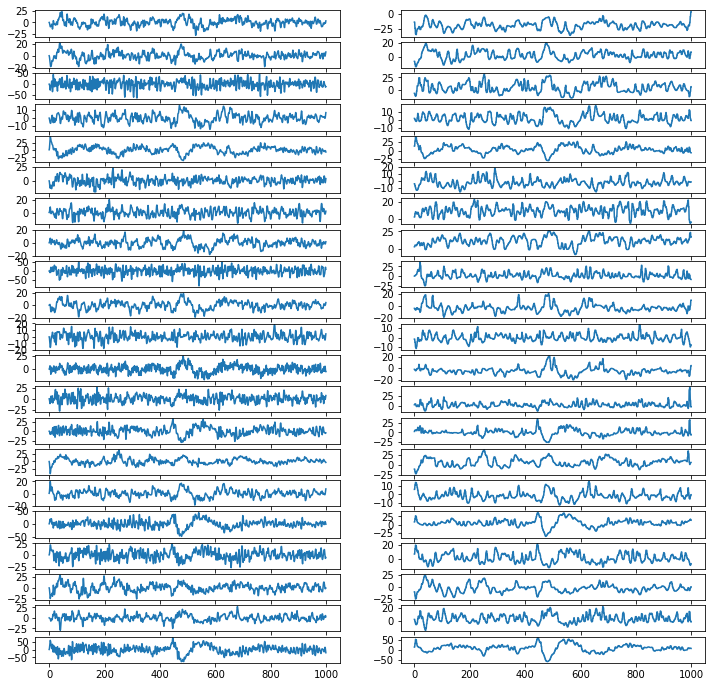

In [25]:
show_for_instance(2)

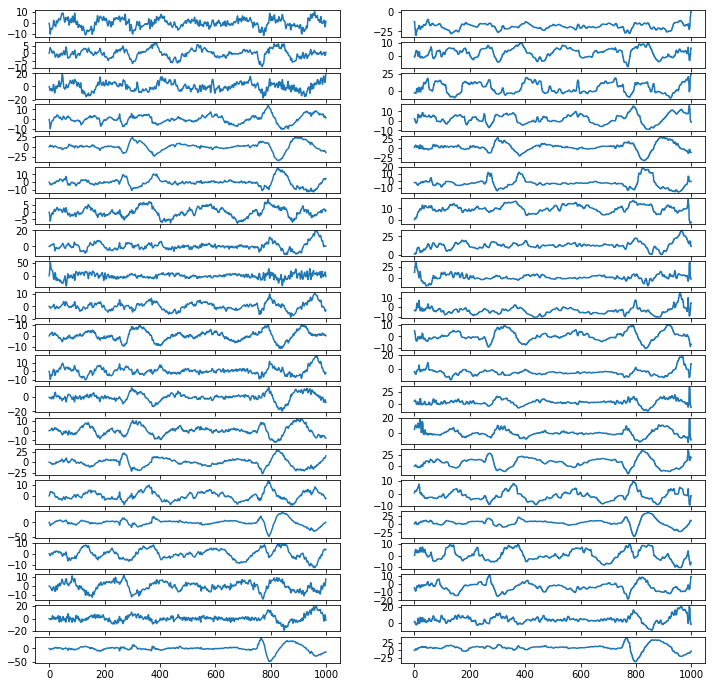

In [26]:
show_for_instance(3)

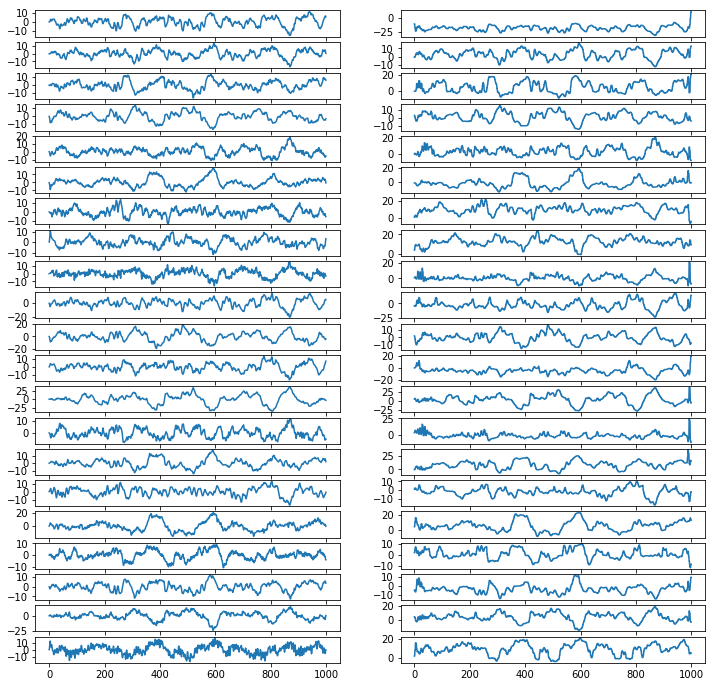

In [27]:
show_for_instance(4)

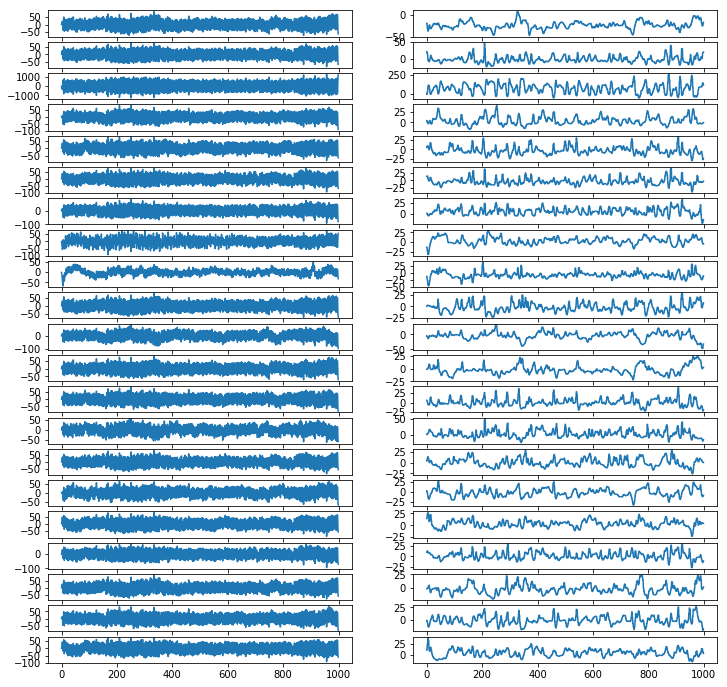

In [28]:
show_for_instance(5)

# Try to create an unshuffled feature set for each data

First count number of records in each dataset

In [8]:
train_fn = "/n/scratch2/ms994/train_4s.tfr"
valid_fn = "/n/scratch2/ms994/valid_4s.tfr"
test_fn = "/n/scratch2/ms994/test_4s.tfr"

In [9]:
num_train = 0
for record in tf.python_io.tf_record_iterator(train_fn):
 num_train += 1

In [10]:
num_valid = 0
for record in tf.python_io.tf_record_iterator(valid_fn):
 num_valid += 1

In [11]:
num_test = 0
for record in tf.python_io.tf_record_iterator(test_fn):
 num_test += 1

In [12]:
num_train, num_valid, num_test

(203894, 81251, 129670)

In [13]:
tfm

<module 'preprocessingV2.tfrecord_mappers' from '/home/ms994/dbmi_eeg_clustering/preprocessingV2/tfrecord_mappers.py'>

In [14]:
import tf
def get_batched_dataset(filenames, map_function=tfm.read_tfrecord_autoencoder, max_queue_size=100):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False
    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=1, num_parallel_calls=1)
    dataset = dataset.map(map_function, num_parallel_calls=1)
    dataset = dataset.repeat()
    dataset = dataset.batch(128, drop_remainder=True)
    dataset = dataset.prefetch(max_queue_size)
    return dataset

In [15]:
train_dataset = get_batched_dataset(train_fn)

In [16]:
valid_dataset = get_batched_dataset(valid_fn)

In [17]:
test_dataset = get_batched_dataset(test_fn)

In [18]:
model = tf.keras.models.load_model("/n/scratch2/ms994/cnn_lstm_autoencoder_seizure.h5")

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


In [19]:
g_noise=1
num_lstm_layers=3
lstm_h=128
cnn2d_n_k=2
num_cnn_layers=3
lr = 0.001

inputLayer = tf.keras.layers.Input((1000,21, 1))
x = inputLayer

x = tf.keras.layers.GaussianNoise(g_noise)(x)
for i in range(num_cnn_layers):
#     x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(cnn2d_n_k**i, (3,3), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool2D((2,1))(x)
old_x_shape = (x).get_shape().as_list()
x = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]) * int(x.shape[3])), name="LSTM_Reshape")(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.CuDNNLSTM(int(lstm_h/2**j), return_sequences=True, kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.1, l2=0.1))(x)
    x = tf.keras.layers.LeakyReLU()(x)
x_shared = x
encoder_model = tf.keras.Model(inputs=inputLayer, outputs=x_shared)


In [20]:
for i, layer in enumerate(encoder_model.layers):
    layer.set_weights(model.layers[i].get_weights())

In [21]:
encoder_model.compile("adam", "mean_squared_error")

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


In [22]:
encoded_train = encoder_model.predict(train_dataset, steps=int(num_train/128))

In [23]:
reload(tfm)

<module 'preprocessingV2.tfrecord_mappers' from '/home/ms994/dbmi_eeg_clustering/preprocessingV2/tfrecord_mappers.py'>

In [24]:
y_seizure = []
y_montage = []
y_session = []
y_subtype = []
with tf.Session() as sess:
    dataset = get_batched_dataset(train_fn, map_function=tfm.read_tfrecord_return_outputs)
    iterator = dataset.make_one_shot_iterator()
    y = iterator.get_next()
    for i in range(int(num_train/128)):
        y_seizure.append(y[0].eval())
        y_subtype.append(y[1].eval())
        y_session.append(y[2].eval())
        y_montage.append(y[3].eval())

In [25]:
pkl.dump((encoded_train, (np.hstack(y_seizure), np.hstack(y_subtype), np.hstack(y_session), np.vstack(y_montage))), open("/n/scratch2/ms994/encoded_train_cnn_lstm.pkl","wb"))

In [26]:
encoded_train.shape, np.vstack(y_montage).shape

((203776, 125, 32), (203776, 22))

In [27]:
encoded_valid = encoder_model.predict(valid_dataset, steps=int(num_valid/128))

In [28]:
y_seizure = []
y_montage = []
y_session = []
y_subtype = []
with tf.Session() as sess:
    dataset = get_batched_dataset(valid_fn, map_function=tfm.read_tfrecord_return_outputs)
    iterator = dataset.make_one_shot_iterator()
    y = iterator.get_next()
    for i in range(int(num_train/128)):
        y_seizure.append(y[0].eval())
        y_subtype.append(y[1].eval())
        y_session.append(y[2].eval())
        y_montage.append(y[3].eval())

In [29]:
pkl.dump((encoded_valid, (np.hstack(y_seizure), np.hstack(y_subtype), np.hstack(y_session), np.vstack(y_montage))), open("/n/scratch2/ms994/encoded_valid_cnn_lstm.pkl","wb"))

In [30]:
encoded_test = encoder_model.predict(test_dataset, steps=int(num_valid/128))

In [31]:
y_seizure = []
y_montage = []
y_session = []
y_subtype = []
with tf.Session() as sess:
    dataset = get_batched_dataset(test_fn, map_function=tfm.read_tfrecord_return_outputs)
    iterator = dataset.make_one_shot_iterator()
    y = iterator.get_next()
    for i in range(int(num_train/128)):
        y_seizure.append(y[0].eval())
        y_subtype.append(y[1].eval())
        y_session.append(y[2].eval())
        y_montage.append(y[3].eval())

In [32]:
pkl.dump((encoded_test, (np.hstack(y_seizure), np.hstack(y_subtype), np.hstack(y_session), np.vstack(y_montage))), open("/n/scratch2/ms994/encoded_test_cnn_lstm.pkl","wb"))

# Try denoising, but with dense layer in center, with spatial dropout

In [4]:
g_noise=1
num_lstm_layers=4
lstm_h=256
cnn2d_n_k=2
num_cnn_layers=3
lr = 0.001

inputLayer = tf.keras.layers.Input((1000,21, 1))
x = inputLayer

x = tf.keras.layers.GaussianNoise(g_noise)(x)
for i in range(num_cnn_layers):
#     x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(cnn2d_n_k**(i+1), (3,3), padding="same")(x)
    x = tf.keras.layers.SpatialDropout2D(0.25)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool2D((2,1))(x)
old_x_shape = (x).get_shape().as_list()
x = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]) * int(x.shape[3])), name="LSTM_Reshape")(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.CuDNNLSTM(int(lstm_h/2**j), return_sequences=True, kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.1, l2=0.1))(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
# x = tf.keras.layers.Flatten()(x)
# for i in range(3):
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Dense(int(1024/2**i))(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = tf.keras.layers.Dropout(0.25)(x)
# x = tf.keras.layers.BatchNormalization(name="encode_out")(x)





# #decoder
# for i in range(3):
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Dense(int(1024/2**(2-i)))(x)
#     x = tf.keras.layers.LeakyReLU()(x)
# x = tf.keras.layers.Dense((125*32))(x)
# x = tf.keras.layers.Reshape((125,32))(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.CuDNNLSTM(int(lstm_h/2**(num_lstm_layers-j-1)), return_sequences=True, kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.1, l2=0.1))(x)
    x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.CuDNNLSTM(old_x_shape[2]*old_x_shape[3], return_sequences=True, name="lstm_decode")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Reshape(old_x_shape[1:], name="reshape_decode")(x)
for i in range(num_cnn_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(cnn2d_n_k**(num_cnn_layers-i), (3,3), padding="same")(x)
    x = tf.keras.layers.UpSampling2D((2,1))(x)
    x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Conv2D(1, (3,3), padding="same")(x)
x_decode = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]), int(x.shape[3])), name="decode")(x)

model = tf.keras.Model(inputs=inputLayer, outputs=x_decode)
model.compile(tf.keras.optimizers.Adam(lr=lr),  loss=["logcosh"], metrics=["mean_squared_error"])
batch_size=128
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000, 21, 1)       0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 1000, 21, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1000, 21, 2)       20        
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 1000, 21, 2)       0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1000, 21, 2)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 500, 21, 2)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 500, 21, 4)        76        
__________

In [7]:
modelCheck = tf.keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/cnn_lstm_autoencoder_seizure_spatial_dropout.h5", save_best_only=True, verbose=1)
earlyStopping = tf.keras.callbacks.EarlyStopping(patience=20)
history = model.fit(train_unbalanced, validation_dat a=valid_data, steps_per_epoch=500, validation_steps=100, epochs=1000, callbacks=[modelCheck, earlyStopping])

Epoch 1/1000
499/500 [============================>.] - ETA: 0s - loss: 1522.5043 - mean_squared_error: 102.9208
Epoch 00001: val_loss improved from inf to 3712.23097, saving model to /n/scratch2/ms994/cnn_lstm_autoencoder_seizure_spatial_dropout.h5
500/500 [==============================] - 205s 410ms/step - loss: 1521.5390 - mean_squared_error: 102.8747 - val_loss: 3712.2310 - val_mean_squared_error: 13985.5703
Epoch 2/1000
499/500 [============================>.] - ETA: 0s - loss: 987.1906 - mean_squared_error: 67.1603
Epoch 00002: val_loss improved from 3712.23097 to 3292.61578, saving model to /n/scratch2/ms994/cnn_lstm_autoencoder_seizure_spatial_dropout.h5
500/500 [==============================] - 192s 383ms/step - loss: 987.0955 - mean_squared_error: 67.1459 - val_loss: 3292.6158 - val_mean_squared_error: 13668.6895
Epoch 3/1000
499/500 [============================>.] - ETA: 0s - loss: 932.4196 - mean_squared_error: 62.8677
Epoch 00003: val_loss improved from 3292.61578 to 31

Epoch 23/1000
499/500 [============================>.] - ETA: 0s - loss: 727.9496 - mean_squared_error: 48.0746
Epoch 00023: val_loss did not improve from 2572.15198
500/500 [==============================] - 191s 382ms/step - loss: 727.9262 - mean_squared_error: 48.0738 - val_loss: 2634.3302 - val_mean_squared_error: 13647.0107
Epoch 24/1000
499/500 [============================>.] - ETA: 0s - loss: 725.8481 - mean_squared_error: 47.8679
Epoch 00024: val_loss did not improve from 2572.15198
500/500 [==============================] - 191s 382ms/step - loss: 725.8778 - mean_squared_error: 47.8690 - val_loss: 2683.1797 - val_mean_squared_error: 12882.9238
Epoch 25/1000
499/500 [============================>.] - ETA: 0s - loss: 722.4458 - mean_squared_error: 47.8207
Epoch 00025: val_loss did not improve from 2572.15198
500/500 [==============================] - 191s 382ms/step - loss: 722.6284 - mean_squared_error: 47.8471 - val_loss: 2751.7804 - val_mean_squared_error: 13934.1074
Epoch 2

# Just do CNN Layers

In [22]:
reload(tfm)

<module 'preprocessingV2.tfrecord_mappers' from '/home/ms994/dbmi_eeg_clustering/preprocessingV2/tfrecord_mappers.py'>

In [36]:
train_unbalanced = tfm.get_batched_dataset(["/n/scratch2/ms994/train_4s.tfr"], map_function=tfm.read_tfrecord_autoencoder_992_output, batch_size=256,  is_train=True)
valid_data = tfm.get_batched_dataset(["/n/scratch2/ms994/valid_4s.tfr"], map_function=tfm.read_tfrecord_autoencoder_992_output,batch_size=256, is_train=False)
test_data = tfm.get_batched_dataset(["/n/scratch2/ms994/test_4s.tfr"], map_function=tfm.read_tfrecord_autoencoder_992_output,batch_size=256, is_train=False)

In [38]:
g_noise=2
num_lstm_layers=4
lstm_h=256
cnn2d_n_k=4
num_cnn_layers=4
lr = 0.001

inputLayer = tf.keras.layers.Input((1000,21, 1))
x = inputLayer

x = tf.keras.layers.GaussianNoise(g_noise)(x)
for i in range(num_cnn_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(min(2**i, cnn2d_n_k), (3,3), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool2D((2,1))(x)

x = tf.keras.layers.Conv2D(cnn2d_n_k, (3,3), padding="same")(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.MaxPool2D((2,3))(x)



x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(250)(x)
x = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(125)(x)
x = tf.keras.layers.LeakyReLU(name="encoder_output")(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(125)(x)
x = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(250)(x)
x = tf.keras.layers.LeakyReLU()(x)


x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(31*7*4)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Reshape((31,7,4))(x)

    
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(cnn2d_n_k, (3,3), padding="same")(x)
x = tf.keras.layers.UpSampling2D((2,3))(x)
x = tf.keras.layers.LeakyReLU()(x)
    
    
for i in range(num_cnn_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(min(2**(num_cnn_layers-i-1), cnn2d_n_k), (3,3), padding="same")(x)
    x = tf.keras.layers.UpSampling2D((2,1))(x)
    x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Conv2D(1, (3,3), padding="same")(x) # use an output without leakyReLU to decode negative nums
x_decode = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]), int(x.shape[3])), name="decode")(x)

model = tf.keras.Model(inputs=inputLayer, outputs=x_decode)
model.compile(tf.keras.optimizers.Adam(lr=lr),  loss=["logcosh"], metrics=["mean_squared_error"])
batch_size=128
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 1000, 21, 1)       0         
_________________________________________________________________
gaussian_noise_21 (GaussianN (None, 1000, 21, 1)       0         
_________________________________________________________________
batch_normalization_v1_174 ( (None, 1000, 21, 1)       4         
_________________________________________________________________
conv2d_183 (Conv2D)          (None, 1000, 21, 1)       10        
_________________________________________________________________
leaky_re_lu_201 (LeakyReLU)  (None, 1000, 21, 1)       0         
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 500, 21, 1)        0         
_________________________________________________________________
batch_normalization_v1_175 ( (None, 500, 21, 1)        4         
__________

In [39]:
modelCheck = tf.keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/cnn_only_autoencoder_seizure_spatial_dropout.h5", save_best_only=True, verbose=1)
earlyStopping = tf.keras.callbacks.EarlyStopping(patience=20)
history = model.fit(train_unbalanced, validation_data=valid_data, steps_per_epoch=500, validation_steps=200, epochs=1000, callbacks=[modelCheck, earlyStopping])

Epoch 1/1000
499/500 [============================>.] - ETA: 0s - loss: 1591.1959 - mean_squared_error: 129.6308
Epoch 00001: val_loss improved from inf to 3640.18270, saving model to /n/scratch2/ms994/cnn_only_autoencoder_seizure_spatial_dropout.h5
500/500 [==============================] - 222s 444ms/step - loss: 1591.1203 - mean_squared_error: 129.6228 - val_loss: 3640.1827 - val_mean_squared_error: 13896.3682
Epoch 2/1000
499/500 [============================>.] - ETA: 0s - loss: 1429.1828 - mean_squared_error: 109.0233
Epoch 00002: val_loss improved from 3640.18270 to 3376.65757, saving model to /n/scratch2/ms994/cnn_only_autoencoder_seizure_spatial_dropout.h5
500/500 [==============================] - 151s 302ms/step - loss: 1429.0067 - mean_squared_error: 108.9944 - val_loss: 3376.6576 - val_mean_squared_error: 13791.6299
Epoch 3/1000
499/500 [============================>.] - ETA: 0s - loss: 1372.5549 - mean_squared_error: 102.2568
Epoch 00003: val_loss did not improve from 337

Epoch 25/1000
499/500 [============================>.] - ETA: 0s - loss: 1255.9921 - mean_squared_error: 89.4610
Epoch 00025: val_loss did not improve from 3195.46507
500/500 [==============================] - 158s 316ms/step - loss: 1255.9814 - mean_squared_error: 89.4693 - val_loss: 6750.1557 - val_mean_squared_error: 14364.4170
Epoch 26/1000
499/500 [============================>.] - ETA: 0s - loss: 1253.3296 - mean_squared_error: 88.9929
Epoch 00026: val_loss did not improve from 3195.46507
500/500 [==============================] - 159s 318ms/step - loss: 1253.3501 - mean_squared_error: 88.9830 - val_loss: 11250.8239 - val_mean_squared_error: 15750.7383
Epoch 27/1000
499/500 [============================>.] - ETA: 0s - loss: 1254.1219 - mean_squared_error: 89.0658
Epoch 00027: val_loss did not improve from 3195.46507
500/500 [==============================] - 168s 336ms/step - loss: 1253.9616 - mean_squared_error: 89.0378 - val_loss: 5532.3850 - val_mean_squared_error: 13876.2793
